# Assignment 6: Feature selection and regularization

# Total: /100

## Instructions

* Complete the assignment

* Once the notebook is complete, **restart** your kernel and **rerun** your cells

* Submit your completed notebook to owl by the deadline

* You may use any python library functions you wish to complete the assignment

In [1]:
# You may need these
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
import sklearn.linear_model as skl
from sklearn import preprocessing
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from IPython.display import display

# To get geo info of IP addresses:
#!pip install maxminddb-geolite2
from geolite2 import geolite2

seed = 2023
np.random.seed(seed)

## Question 1: /20 pts

The dataset `customer_data.csv` lists certain attributes providing valuable insights into customer behavior and demographics:

- **full.name**: Customer's full name
- **ip.address**: Customer's IP address
- **region**: Customer's geographical region
- **age**: Customer's age
- **items**: Number of items purchased by the customer
- **amount**: The total amount spent by the customer

Businesses can leverage this dataset to make data-driven decisions, understand customer preferences, and tailor their strategies to meet customer needs and interests.


### 1.1 Load the dataset and display the first 5 rows.

In [2]:
#your code here
df = pd.read_csv('customer_data.csv')

df.head()


,full.name,ip.address,region,in.store,age,items,amount
0,Carter Stokes,NaN,2,0,37,4,281.03
1,Jacob Jerde,NaN,2,0,35,2,219.51
2,Tressa Ratke,192.90.208.202,4,1,45,3,1525.70
3,Rudolf Abshire,251.55.128.164,3,1,46,3,715.25
4,Theresa Davis,182.19.192.186,1,1,33,4,1937.50


### 1.2 First, remove any rows where the entry of "Age" column is below 18 or above 80, and then extract two new features from `ip.address`: one called `latitude` and the other `longitude`. Use the package `geolite2` for the conversion of the IP addresses to latitude and longitude. Use [pandas.DataFrame.apply](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) to do the conversion (in a vectorized way) in one go for each new feature. Avoid using `for` loops. At the end, drop the column `ip.address` as well as any rows with a missing value. Display the first 5 rows of the new dataframe and report its shape.

In [3]:
#your code here
reader = geolite2.reader()

def ipToCoordinates(ip):
    response = reader.get(ip)
    if response and 'location' in response:
        return response['location']['latitude'], response['location']['longitude']
    else:
        return None, None

df = df.dropna()
df.head()
df = df[(18 <= df['age']) & (df['age'] <= 80)]
df[['latitude', 'longitude']] = df['ip.address'].apply(ipToCoordinates).apply(pd.Series)
df = df.drop(columns=['ip.address'])
df = df.dropna()
reader.close()

### 1.3 Perform one-hot encoding on the `region` column using pd.get_dummies(). Display the first 5 rows of the encoded dataframe.

In [4]:
#your code here
df = pd.get_dummies(df, columns=['region'], prefix='region')
df.head()

,full.name,in.store,age,items,amount,latitude,longitude,region_1,region_3,region_4
2,Tressa Ratke,1,45,3,1525.70,42.5879,-71.3498,False,False,True
4,Theresa Davis,1,33,4,1937.50,1.2931,103.8558,True,False,False
7,Keitha Mosciski,1,66,5,819.98,40.0842,-82.9378,False,True,False
8,Hortense Streich,1,51,5,908.31,37.7510,-97.8220,True,False,False
9,Carl Price,1,47,3,767.54,41.3969,-87.3274,True,False,False


### 1.4 Calculate the natural logarithm of the column reporting clients' total amount spent and store it as a new column `log_amount`. Create your design matrix `X` and target vector `y` with `log_amount` as target (No training/test splitting yet).



In [5]:
#your code here
df['log_amount'] = np.log(df['amount'])

X = df.drop(columns=['full.name', 'log_amount', 'amount'])
y = df['log_amount']

### 1.5 Build a new design matrix by applying polynomial expansion using `PolynomialFeatures()` on `X` with degree=2. Do not include the column with power 0 (*i.e.*, the column with all elements being 1) and make sure to not set the argument `interaction_only` to `True`.


In [6]:
#your code here
poly = PolynomialFeatures(degree=2)
X_transform = poly.fit_transform(X)


### 1.6 Standardize your design matrix from Question 1.5 using `StandardScaler()`, and store the result as a Pandas dataframe.

In [7]:
#your code here
X_transform = StandardScaler().fit_transform(X_transform)
X = pd.DataFrame(X_transform)

## Question 2: /7 pts



### 2.1 Split the data into training and test sets. Hold out 30% of observations as the test set. How many observations are in your training dataset? What is the average value of the target variable in the training dataset (rounded to 2 decimal places)?

In [8]:
#your code here
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print(f'Num examples: {y_train.shape[0]}')
print(f'Average: {np.round(np.average(y_train), 2)}')


Num examples: 24012
Average: 6.38


## Question 3: /23 pts



### 3.1 Create a SciKit Learn `Ridge` regression object. Train it on the training data using an `alpha` of $4.0$ and do fit the intercept.

In [9]:
#your code here
ridge = skl.Ridge(alpha=4.0, fit_intercept=True)
ridge.fit(X_train, y_train)

Ridge(alpha=4.0)

### 3.2 Now use `RidgeCV` to find the best `alpha` for the penalty term through a 5-fold cross-validation. As input for `alpha`, your code must try integer values from 30 to 50 inclusive. Report the `alpha` that yields the smallest loss.

In [10]:
#your code here
alphas = list(range(30, 51))
ridge_cv = skl.RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv.fit(X_train, y_train)
best_alpha = ridge_cv.alpha_
cv_scores = ridge_cv.cv_values_
min_cv_loss = np.min(np.mean(cv_scores, axis=0))
print(f"Best alpha: {best_alpha}")
print(f"Min CV loss: {min_cv_loss}")

Best alpha: 50
Min CV loss: 0.6068101521679439


### 3.3 Fit a `Ridge` regression on the training data with the best `alpha` found in the previous question.

In [11]:
#your code here
best_ridge = skl.Ridge(alpha=best_alpha, fit_intercept=True)
best_ridge.fit(X_train, y_train)

Ridge(alpha=50)

### 3.4 Fit a simple `LinearRegression` without any penalty using the training data (again, `fit_intercept=True`). Compare the regression coefficients obtained in questions 3.1, 3.3 and 3.4. How do they compare?

In [12]:
linear_model = skl.LinearRegression(fit_intercept=True)
linear_model.fit(X_train, y_train)

print("Ridge regression:", ridge.coef_)
print("Ridge with best alpha:", best_ridge.coef_)
print("LinearRegression:", linear_model.coef_)

Ridge regression: [ 0.          0.          0.01455749 -0.00350823  0.01543897 -0.00422758
  0.03827109 -0.07041441  0.02719969  0.          0.01455749 -0.00350823
  0.01543897 -0.00422758  0.03827109 -0.07041441  0.02719969 -0.07885602
  0.00312703 -0.02454876  0.00834369 -0.13087926  0.09126955  0.06130146
  0.00673331 -0.00388706  0.00181563 -0.01065537 -0.00328963  0.01143578
 -0.01449441  0.01122582  0.01375545 -0.00031509  0.00059803 -0.01082604
  0.00100642 -0.00593276 -0.00300118  0.03827109  0.          0.
 -0.07041441  0.          0.02719969]
Ridge with best alpha: [ 0.          0.          0.00993766 -0.0034785   0.01480369 -0.00416112
  0.03749142 -0.06890624  0.02657528  0.          0.00993766 -0.0034785
  0.01480369 -0.00416112  0.03749142 -0.06890624  0.02657528 -0.06986678
  0.00330268 -0.02311681  0.00820416 -0.12965258  0.08656712  0.06218877
  0.00634897 -0.00364156  0.00176563 -0.01033593 -0.00376528  0.01157068
 -0.01438091  0.01116698  0.01364761 -0.00100866  0.00

#### YOUR ANSWER HERE

The coefficients of the linear regression model have the largest magnitude, followed by the ridge regression, followed by the ridge regression with the best alpha. This is as expected: the ridge regression penalizes large coefficients.


### 3.5 Use your trained linear regression models in Q3.3 and Q3.4 to predict over the test set and print the median of their perdictions.

In [13]:
#your code here
best_ridge_preds = best_ridge.predict(X_test)
linear_preds = linear_model.predict(X_test)

best_ridge_median = np.median(best_ridge_preds)
linear_median = np.median(linear_preds)

print(f'Median predictions (best ridge):', best_ridge_median)
print(f'Median predictions (linear regression):', linear_median)

Median predictions (best ridge): 6.387260136528907
Median predictions (linear regression): 6.386960923621329


## Question 4: /25 pts



### 4.1 Fit a Lasso regression to the train dataset using lasso_path(). Show the full path of the first 20 coefficients of the Lasso regression. Include eps=8e-3 and n_alphas=50. Describe the trends you see in the figure.

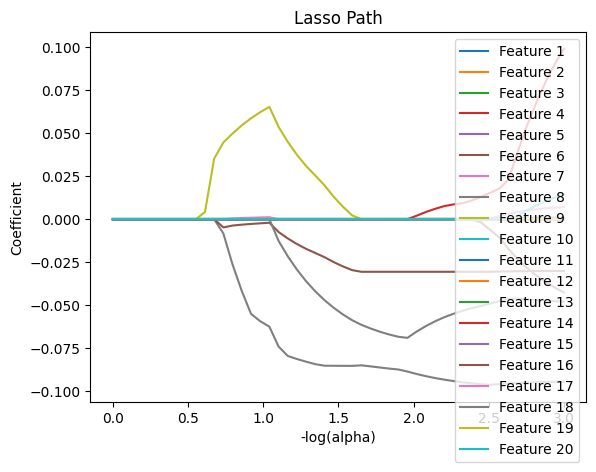

In [14]:
#your code here
alphas, coefs, _ = skl.lasso_path(X_train, y_train, eps=8e-3, alphas=np.logspace(0, -3, 50))

neg_log_alphas_lasso = -np.log10(alphas)
for i in range(20):
    plt.plot(neg_log_alphas_lasso, coefs[i], label=f'Feature {i+1}')

plt.xlabel('-log(alpha)')
plt.ylabel('Coefficient')
plt.title('Lasso Path')
plt.legend()
plt.show()

### 4.2 Use Scikit Learn's cross-validated LASSO to automatically search for the best alpha of the LASSO regression on the training set with intercept. Include arguments `eps=8e-3`, `n_alphas=30`, `tol=0.001`, `cv=5`, and `random_state=seed`. Report the best tuning parameters and the number of coefficients that the model shrinks to zero.

In [15]:
#your code here
lasso_cv = skl.LassoCV(eps=8e-3, n_alphas=30, tol=0.001, cv=5, random_state=seed)
lasso_cv.fit(X_train, y_train)

best_alpha = lasso_cv.alpha_
zero_coef_count = np.sum(lasso_cv.coef_ == 0)
print(f"Best alpha: {best_alpha}")
print(f"Number of coefficients that shrink to zero: {zero_coef_count}")


Best alpha: 0.002989343094570176
Number of coefficients that shrink to zero: 29



### 4.3 Use Scikit Learn's cross-validated ElasticNet to automatically search for the best tuning parameters of the ElasticNet regression (with intercept) on the training set. Include the same arguments as in question 4.2 as well as `l1_ratio=[0.7, 0.9, 0.95, 0.99, 1]`. Report the best tuning parameters. Is the ElasticNet regression model equivalent to the Lasso regression? Briefly describe how they defer and under what circumstances they become the same.

In [16]:
#your code here
l1_ratios = [0.7, 0.9, 0.95, 0.99, 1]
elastic_net_cv = skl.ElasticNetCV(eps=8e-3, n_alphas=30, tol=0.001, cv=5, l1_ratio=l1_ratios, random_state=seed)
elastic_net_cv.fit(X_train, y_train)
best_alpha = elastic_net_cv.alpha_
best_l1_ratio = elastic_net_cv.l1_ratio_
print(f"Best alpha: {best_alpha}")
print(f"Best l1 ratio: {best_l1_ratio}")

Best alpha: 0.002989343094570176
Best l1 ratio: 1.0


#### YOUR ANSWER HERE
ElasticNet combines both Lasso and ridge regularization. The ratio describes the ratio of Lasso to ridge regularization. In this case, the ratio is 1, which indicates that the best regularization is comprised entirely of Lasso reguarlization. So, in this case, the models are equivalent, however, in another case, the best regularization might be a mix of both Lasso and ridge, for a ratio of <1.

## Question 5 : /16 pts



### 5.1 Use `SequentialFeatureSelector()` to conduct forward selection for the features of the Ridge model tuned in Q 3.3. Include the argument `n_features_to_select=20`. Report the indices of the selected features.

In [17]:
#your code here
from sklearn.feature_selection import SequentialFeatureSelector

feature_selector = SequentialFeatureSelector(best_ridge, n_features_to_select=20, direction='forward')
feature_selector.fit(X_train, y_train)
selected_feature_indices = feature_selector.get_support(indices=True)
print("Indices:", selected_feature_indices)

Indices: [ 0  1  2  5  6  7  8  9 10 14 15 17 21 31 36 39 40 41 42 43]


### 5.2 Fit a regular `LinearRegression` (with `fit_intercept=True`) on the training set using the selected features from the previous question. Print the first 3 coefficients of your model.

In [18]:
#your code here
X_train_selected = X_train.iloc[:, selected_feature_indices]
linear_model_selected = skl.LinearRegression(fit_intercept=True)
linear_model_selected.fit(X_train_selected, y_train)

# Print the first 3 coefficients of the model
coeffs_selected = linear_model_selected.coef_[:3]
print("First 3 coefficients:", coeffs_selected)

First 3 coefficients: [ 0.00000000e+00 -1.81233725e+08  6.22534103e+10]


## Question 6: /9 pts



### 6.1 Make predictions on the test set using models from questions 3.3, 4.2, 4.3, and 5.2, respectively. Create a DataFrame with  predicted values obtained from the different models. Name the columns of the dataframe consistent with the names used for the models, or their question number. Display the first 5 rows of this dataframe.

In [19]:
#your code here
X_test_selected = X_test.iloc[:, selected_feature_indices]

preds_3_3 = best_ridge.predict(X_test)
preds_4_2 = lasso_cv.predict(X_test)
preds_4_3 = elastic_net_cv.predict(X_test)
preds_5_2 = linear_model_selected.predict(X_test_selected)

preds_df = pd.DataFrame({
    "3.3": preds_3_3,
    "4.2": preds_4_2,
    "4.3": preds_4_3,
    "5.2": preds_5_2
})

# Display the first 5 rows of the DataFrame
print(preds_df.head())

        3.3       4.2       4.3       5.2
0  6.319697  6.298637  6.298637  6.307482
1  6.718193  6.716664  6.716664  6.698717
2  6.034157  6.024918  6.024918  6.042589
3  6.493383  6.453577  6.453577  6.475695
4  6.441789  6.423090  6.423090  6.421984


### 6.2 Use `mean_squared_error` as your scorer to assess the performance of the different models (those reported in the previous question) based on all the predicted values over test set. Based on this scorer which model is the best?

In [20]:
#your code here
from sklearn.metrics import mean_squared_error

mses = {model_name: mean_squared_error(y_test, preds_df[model_name]) for model_name in ['3.3', '4.2', '4.3', '5.2']}


for model, mse in mses.items():
    print(f'{model}: {mse}')


3.3: 0.606334036593972
4.2: 0.6057642133253611
4.3: 0.6057642133253611
5.2: 0.6055898281279666


#### YOUR ANSWER HERE

Based on the MSE, the model in 5.2 is the best.